# BERT Grocery Recommender

Welcome to this Jupyter notebook that will use a BERT (Bidirectional Encoder Representations from Transformers) model to make grocery product recommendations based on a customer's past purchasing patterns. In this notebook, we will use BERT's ability to generate contextualized embeddings for related products. We will then combine this information with the customer's past purchase history to recommend grocery products that are likely to be well-received. By the end of this notebook, you will have a better understanding of how BERT can be used in a practical application and how it can help improve product recommendations.

BERT is a pre-trained deep learning model developed by Google for generating contextualized word embeddings that capture the meaning of a word in a given context. It uses the transformer architecture and processes text bidirectionally, allowing it to capture contextual information from both past and future words in a sentence. BERT is pre-trained on a large corpus of text using unsupervised learning tasks, such as Masked Language Modeling (MLM) and Next Sentence Prediction (NSP).

After pre-training, BERT can be fine-tuned on downstream tasks with small amounts of task-specific training data, making it an efficient and effective approach for a wide range of natural language processing (NLP) tasks. BERT has become one of the most widely used models in the field of NLP.


### Import Python Libraries

In [1]:
import sys
!{sys.executable} -m pip install torch transformers onnx adjustText

In [47]:
from adjustText import adjust_text
from IPython.display import display, HTML
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.spatial.distance import cosine
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import time
import torch
import torch.onnx
from transformers import BertTokenizer, BertModel
import warnings

In [3]:
warnings.filterwarnings("ignore")

### Load the Instacart Data

We are using the [Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/data) dataset to track customers' orders over time. The main focus is on the *orders.csv* file, where each line represents a relation between a user and the order. In other words, each line has information on *userid* (user who made the order) and *orderid*. Note there is no information about products in this table. Product information related to specific orders is stored in the *order_product__*.csv* dataset.

In [4]:
order_products_train = pd.read_csv('./order_products__train.csv')
n_records = 1000000
order_products_train = order_products_train.tail(n_records)
order_products_train

,order_id,product_id,add_to_cart_order,reordered
384617,939060,40216,16,0
384618,939060,12576,17,0
384619,939060,45747,18,0
384620,939126,2198,1,1
384621,939126,37068,2,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [5]:
order_products_prior = pd.read_csv('./order_products__prior.csv')
order_products_prior = order_products_prior.head(n_records)
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
999995,105629,18670,9,1
999996,105629,7010,10,1
999997,105629,3142,11,1
999998,105629,28849,12,0


In [6]:
products = pd.read_csv('./products.csv')
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [7]:
orders = pd.read_csv('./orders.csv')
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [8]:
order_products = pd.concat([order_products_train, order_products_prior], ignore_index=True)
order_products

,order_id,product_id,add_to_cart_order,reordered
0,939060,40216,16,0
1,939060,12576,17,0
2,939060,45747,18,0
3,939126,2198,1,1
4,939126,37068,2,1
...,...,...,...,...
1999995,105629,18670,9,1
1999996,105629,7010,10,1
1999997,105629,3142,11,1
1999998,105629,28849,12,0


In [9]:
# Combine all of the datasets into one dataframe.
df_all = order_products.merge(products, on="product_id").merge(orders, on="order_id")

In [10]:
df_all

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,939060,40216,16,0,Yukon Gold Potatoes,83,4,26435,train,5,6,17,30.0
1,939060,12576,17,0,Kiwi Sandia Sparkling Water,115,7,26435,train,5,6,17,30.0
2,939060,45747,18,0,Curate Melon Pomelo Sparking Water,115,7,26435,train,5,6,17,30.0
3,1035591,40216,6,0,Yukon Gold Potatoes,83,4,190098,train,21,0,14,30.0
4,1035591,24852,15,1,Banana,24,4,190098,train,21,0,14,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,78886,31646,1,0,Variety of Victorys,27,5,133149,prior,10,4,11,13.0
1999996,79901,22134,1,0,Chili Style Diced Tomatoes,81,15,13065,prior,3,4,18,11.0
1999997,96843,24569,1,0,Witch Hazel For Face & Body,118,11,110738,prior,2,1,18,10.0
1999998,98534,37315,1,0,Fresh Hen Turkey,49,12,4338,prior,4,1,8,11.0


In [11]:
df_all.shape

(2000000, 13)

### Load BERT Model

Create a tokenizer object from the BertTokenizer class, which is used to convert raw text into tokens that can be fed into the BERT model. The model object is created from the BertModel class and is initialized with the pre-trained weights for the 'bert-base-uncased' model. This model can be fine-tuned on a wide range of NLP tasks such as text classification, sentiment analysis, and language understanding. In our case, we are going to predict the next product to recommend to the customer based on the sequence of previously purchased products.

You can see the hierarchical structure of the BERT model with its different deep learning layers by simply displaying the model object.

In [12]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Generate product embeddings

BERT embeddings are a way to represent words in a sentence with a vector of numbers that captures the meaning of the word in context. These vectors are generated by a deep neural network such as PyTorch that has been trained on a large amount of text data. 

The key innovation of BERT embeddings is that they are contextualized, meaning that the vector representation of a word depends on the words that come before and after it in the sentence. This allows BERT embeddings to capture the subtle nuances of language that can change the meaning of a word depending on its context.

For example, the word "bank" can have different meanings depending on the context in which it is used. In the sentence "I need to go to the bank to withdraw some money", the word "bank" refers to a financial institution. In the sentence "The river bank was covered in mud", the word "bank" refers to the edge of a river. BERT embeddings are able to capture these contextual differences and generate different vector representations for the word "bank" in each sentence.

These contextualized word embeddings have many applications in NLP, such as sentiment analysis, text classification, and language translation, because they allow algorithms to better understand the meaning of words in context and make more accurate predictions.

In [13]:
def get_bert_embeddings(text, tokenizer, model):
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        output = model(input_ids)
    return output.last_hidden_state[:, 0, :].detach().numpy()

In [14]:
load_dict = True

In [15]:
if not load_dict:
    # We will need to save the embeddings separately because of the time needed to generate them
    print("Generating Product Embeddings")
    unique_products = products['product_name'].unique()
    product_embeddings = np.vstack([get_bert_embeddings(name, tokenizer, model) for name in unique_products])
    product_embedding_dict = dict(zip(unique_products, product_embeddings))

In [16]:
file_spec = './product_embeddings.pkl'
if load_dict:
    print("Loading Product Embeddings")
    with open(file_spec, 'rb') as file:
        product_embedding_dict = pickle.load(file)
else:
    print("Saving Product Embeddings")
    with open(file_spec, 'wb') as file:
        pickle.dump(product_embedding_dict, file)
print(f"The product embedding dictionary is {len(product_embedding_dict)} items in length.")

Loading Product Embeddings
The product embedding dictionary is 49688 items in length.


In [17]:
n_products = 20
all_products = list(product_embedding_dict.keys())
print(f"Showing first {n_products} products in our embedding dictionary")
all_products[:n_products]

Showing first 20 products in our embedding dictionary


['Chocolate Sandwich Cookies',
 'All-Seasons Salt',
 'Robust Golden Unsweetened Oolong Tea',
 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce',
 'Green Chile Anytime Sauce',
 'Dry Nose Oil',
 'Pure Coconut Water With Orange',
 "Cut Russet Potatoes Steam N' Mash",
 'Light Strawberry Blueberry Yogurt',
 'Sparkling Orange Juice & Prickly Pear Beverage',
 'Peach Mango Juice',
 'Chocolate Fudge Layer Cake',
 'Saline Nasal Mist',
 'Fresh Scent Dishwasher Cleaner',
 'Overnight Diapers Size 6',
 'Mint Chocolate Flavored Syrup',
 'Rendered Duck Fat',
 'Pizza for One Suprema  Frozen Pizza',
 'Gluten Free Quinoa Three Cheese & Mushroom Blend',
 'Pomegranate Cranberry & Aloe Vera Enrich Drink']

Word embeddings are a common type of embedding used in natural language processing (NLP). In word embeddings,
each word in a vocabulary is represented by a dense vector, typically with a fixed number of dimensions, in
our case 768. These vectors are designed to capture the semantic meaning of words, so that words with similar
meanings have similar vector representations. In our case, we are relating the approximately 50,000 products
to each other.

In [18]:
product_example = product_embedding_dict['Green Chile Anytime Sauce']
print(f"The vector embedding for each product is length: {len(product_example)}")
n_elements = 10
embedding_sample = product_example[:n_elements]
print(f"Here are the first {n_elements} elements of the embedding vector:\n{embedding_sample}")

The vector embedding for each product is length: 768
Here are the first 10 elements of the embedding vector:
[-0.6079379  -0.02424314 -0.15218076  0.41404417  0.16926445  0.00221938
 -0.19382751  0.89590913 -0.212102   -0.17228398]


In [19]:
# This code was used for finding common terms amongst the product catalog.
search_product = False
if search_product:
    substring = 'Milk Chocolate Almond'
    # Iterate over the keys and check if the substring is present
    matching_keys = [key for key in product_embedding_dict if substring in key]
    matching_keys

In [20]:
product_labels = ['New York City Slices Gourmet Pizza',
                  'Di Giorno Half & Half Pizza Cheese And Pepperoni',
                  'Italian Sausage & Fire-Roasted Veggie Pizza',
                  'Pizza Squeeze Pizza Sauce',
                  'Calzone Spinach Feta & Tomato',
                  'Pure Coconut Water With Orange',
                  'Grapefruit Sparkling Energy Water',
                  'Water New Zealand',
                  'Red Grapefruit In Water',
                  'Premium Spring Water',
                  'Albacore Tuna in Yellow Coconut Curry',
                  'Yellowfin Tuna Steak',
                  'Ahi Tuna',
                  'Chicken & Tuna Dinner Wet Cat Food',
                  'Turkey Feast Cat Food',
                  'Light Strawberry Blueberry Yogurt',
                  'Yogurt Honey Peanut Bar',
                  'Organic Coconut Yogurt',
                  'Organic Milk',
                  'Reduced Fat 1% Milk']
print(f"We will visualize the embeddings for a selected {len(product_labels)} products.")

We will visualize the embeddings for a selected 20 products.


In [21]:
tsne_embedding_dict = {key: product_embedding_dict[key] for key in product_labels if key in product_embedding_dict}

In [22]:
tsne_embeddings = [value.tolist() for key, value in tsne_embedding_dict.items()]
# Convert embeddings to numpy array
embeddings_array = np.array(tsne_embeddings)

In [23]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

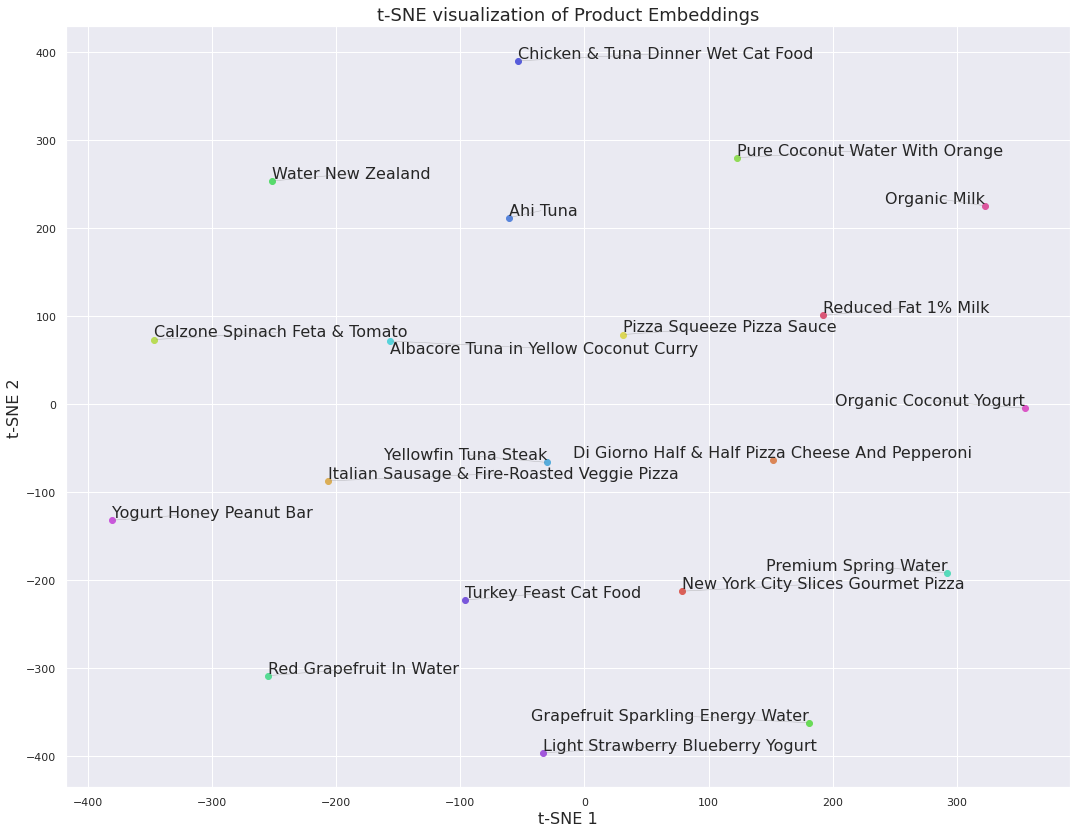

In [24]:
# Plot t-SNE results
sns.set(rc={"figure.figsize": (18, 14)})
palette = sns.color_palette("hls", len(product_labels))

texts = []
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, color=palette[i], alpha=1, label=product_labels[i])
    texts.append(plt.text(x, y, product_labels[i], ha='left', va='bottom', fontsize=16))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1), 
            arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.5, color='grey'))

plt.xlabel("t-SNE 1", fontsize=16)
plt.ylabel("t-SNE 2", fontsize=16)
plt.title("t-SNE visualization of Product Embeddings", fontsize=18)
plt.show()

In the picture above, we can observe some patterns in why certain products are clustered together.

1. Milk and yogurt products are clustered in the upper right-hand quadrant.
2. Pizza-related items are located around the center.
3. There seems to be a fruit dimension along the bottom. 

Keep in mind that this is a relatively small sample, and now we will look at the actual distances below to find the closely related products. We will calculate the cosine similarity for each product pair. Cosine similarity is a measure of similarity between two non-zero vectors in a multi-dimensional space, calculated as the cosine of the angle between the vectors. It ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating orthogonality (no similarity).

In [29]:
def cosine_similarity_func(a, b):
    return 1 - cosine(a, b)

# Compute pairwise cosine similarities
cosine_similarities = np.zeros((n_products, n_products))
for i in range(n_products):
    for j in range(n_products):
        cosine_similarities[i, j] = cosine_similarity_func(tsne_embeddings[i], tsne_embeddings[j])

# Print the cosine similarities
print("Cosine Similarities for Product 1:")
print(cosine_similarities[0])

Cosine Similarities for Product 1:
[1.         0.84515655 0.84799501 0.90251395 0.79701246 0.81835355
 0.88169348 0.83008039 0.8410645  0.8806943  0.77736663 0.78332284
 0.86717872 0.89962635 0.86162994 0.86506719 0.87937468 0.80743984
 0.81532013 0.76467531]


Let's find the "nearest" products for a few of our products.

In [30]:
def get_index_of_second_highest(numbers):
    # Enumerate the list to keep track of indices
    indexed_numbers = list(enumerate(numbers))
    # Sort the list based on the values (second element of each tuple) in descending order
    sorted_numbers = sorted(indexed_numbers, key=lambda x: x[1], reverse=True)
    # Return the index of the second highest element (first element of the second tuple)
    return sorted_numbers[1][0]

product_indices = [0, 14, 19]
for pi in product_indices:
    this_product = product_labels[pi]
    index2 = get_index_of_second_highest(cosine_similarities[pi])
    closest_product = product_labels[index2]
    output_string = f"The closest product to <b>{this_product}</b> is: <b>{closest_product}</b>."
    display(HTML(output_string))

You can now see the limitations of the t-SNE visualization 2D projection shown above. Even though the two cat food products aligned along the vertical dimension, they did not align along the horizontal dimension. When interpreting a 2D projection that was compressed from many dimensions (e.g., 768), focus on the general patterns and not specific individual items.

### Recommender Functions

To make the proper recommendations, we need to first define the following functions:

- **recommend_similar_products**
- **get_last_n_purchased_products**
- **recommend_products_based_on_history**

The function **recommend_similar_products** will accept a product name and return the top N similar products based on cosine similarity.

The function **get_last_n_purchased_products** will return the last N purchased products by a given user.

The function **recommend_products_based_on_history** will make product recommendations for a user based on both the purchasing sequence and the embeddings.

In [35]:
def recommend_similar_products(product_name, product_embedding_dict, top_n=5):
    product_embedding = product_embedding_dict[product_name]
    product_embeddings = np.vstack(list(product_embedding_dict.values()))
    similarity_scores = cosine_similarity(product_embedding.reshape(1, -1), product_embeddings)[0]
    sorted_indices = np.argsort(similarity_scores)[::-1]
    recommended_indices = sorted_indices[1:top_n + 1]
    return [all_products[idx] for idx in recommended_indices]

In [67]:
def get_last_n_purchased_products(user_id, n):
    user_orders = df_all[df_all['user_id'] == user_id].sort_values(by=['order_number', 'add_to_cart_order'], ascending=False)
    return user_orders['product_name'].head(n).tolist()

In [88]:
def recommend_products_based_on_history(user_id, product_embedding_dict, starting_order, n=5, top_n=5):
    last_purchased_products = get_last_n_purchased_products(user_id, n)
    product = last_purchased_products[n - starting_order]
    recommendations = recommend_similar_products(product, product_embedding_dict, top_n=top_n)
    return set(recommendations) - set(last_purchased_products)

### Product Recommender

In [76]:
def print_recommended_products(user_id, product_embedding_dict, starting_order, n):
    recommended_products = recommend_products_based_on_history(user_id, product_embedding_dict, starting_order, n)
    print(f"Recommended products for user {user_id}:")
    for product in recommended_products:
        print("-", product)

In [77]:
user_id = 1
n_history = 10
purchased_products = get_last_n_purchased_products(user_id, n_history)
purchased_products.reverse()
print(f"User {user_id} has purchased the last {n_history} products in the following order:")
for index, product in enumerate(purchased_products):
    print(f"{index+1}: {product}")

User 1 has purchased the last 10 products in the following order:
1: Organic String Cheese
2: 0% Greek Strained Yogurt
3: XL Pick-A-Size Paper Towel Rolls
4: Milk Chocolate Almonds
5: Pistachios
6: Cinnamon Toast Crunch
7: Aged White Cheddar Popcorn
8: Organic Whole Milk
9: Organic Half & Half
10: Zero Calorie Cola


In [96]:
ordered_so_far = 2
print_recommended_products(user_id, product_embedding_dict, ordered_so_far, n_history)

Recommended products for user 1:
- 0% Fat Blueberry Greek Yogurt
- 0% Fat Strawberry Greek Yogurt
- 0% Milkfat Greek Plain Yogurt
- 0% Fat Peach Greek Yogurt
- 0% Fat Vanilla Greek Yogurt


In [97]:
ordered_so_far = 5
print_recommended_products(user_id, product_embedding_dict, ordered_so_far, n_history)

Recommended products for user 1:
- Pinenuts
- Pineapples
- Brussels Sprouts
- Organic Pistachios
- Pomegranates


In [98]:
ordered_so_far = 7
print_recommended_products(user_id, product_embedding_dict, ordered_so_far, n_history)

Recommended products for user 1:
- Organic French Vanilla Protein Shake
- Multi Grain Crispbread
- Flaked Tuna
- Aged White Cheddar Crunchy Popcorn
- Whole Grain Crispbread


### Saving and Loading the Model

The code snippet below uses the **torch.save** function from the PyTorch library to save the state dictionary (state_dict) of a PyTorch model to a file. The state dictionary is a Python dictionary that contains all the learnable parameters (weights and biases) of the model. This is a common way to save and later load the trained parameters of a model in PyTorch.

Likewise, the **torch.load** function from the PyTorch library will retrieve the learnable parameters along with the BERT model itself.

In [42]:
# Save the PyTorch BERT model
torch.save(model.state_dict(), 'bert_model.pt')

In [43]:
# Load the saved PyTorch BERT model
state_dict = torch.load('bert_model.pt')
model = BertModel.from_pretrained('bert-base-uncased', state_dict=state_dict)

### ONXX Export

In [44]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [51]:
# This model may be too big to export to ONNX and is taking at least 15 minutes so far.

export_to_onnx = False
if export_to_onnx:
    # Define an example input tensor
    batch_size, seq_len = 2, 128
    # Sample Tensor
    inputs = torch.randint(low=0, high=30522, size=(2, 128), dtype=torch.long)
    # Export the PyTorch BERT model to ONNX format
    torch.onnx.export(model, inputs, 'bert_model.onnx', verbose=True)